In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import torch
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from PIL import Image
import os
import numpy as np
from torch.autograd import Variable
import matplotlib.pyplot as plt

In [3]:
is_cuda = torch.cuda.is_available()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print('Current cuda device is', device)

Current cuda device is cuda


In [4]:

data_dir = '/content/drive/MyDrive/Deaplearning/d2l_notebooks/d2l-en/pytorch/D2L_assignment/tr'
file_list = os.listdir(data_dir)  # 이미지 파일 리스트를 가져옵니다.
# 데이터 전처리 및 DataLoader 설정
transform = transforms.Compose([
    transforms.Resize((200, 200)),  # imgae 크기 조정
    transforms.ToTensor(),      # image를 tensor로 변환
    # image 정규화 (평균 0.5, 표준 편차 0.5)
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

class InitDataset(Dataset):
    def __init__(self, file_list, transform=None):
        self.file_list = file_list
        self.transform = transform

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        img_path = os.path.join(data_dir, self.file_list[idx])
        image = Image.open(img_path)
        # 파일명에서 나이 정보만 split 추출
        age = int(self.file_list[idx].split("_")[0])

        if self.transform:
            image = self.transform(image)

        return image, age

# 데이터 분할
train_files, val_files = train_test_split(file_list, test_size=0.2, random_state=42)

# DataLoader 설정
train_dataset = InitDataset(train_files, transform=transform)
val_dataset = InitDataset(val_files, transform=transform)
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

In [5]:
import torch.nn as nn

class Image_to_AgePredictionModel(nn.Module):
    def __init__(self):
        super(Image_to_AgePredictionModel, self).__init__()
        # 입력 이미지 크기에 맞는 Fully Connected 레이어
        self.fc = nn.Linear(200 * 200 * 3, 1)
    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten 작업
        x = self.fc(x)
        return x

model = Image_to_AgePredictionModel()
model.to(device)


Image_to_AgePredictionModel(
  (fc): Linear(in_features=120000, out_features=1, bias=True)
)

In [6]:
"""
에폭(epoch) 수 - 데이터셋을 반복하는 횟수

배치 크기(batch size) - 매개변수가 갱신되기 전 신경망을 통해 전파된 데이터 샘플의 수

학습률(learning rate) - 각 배치/에폭에서 모델의 매개변수를 조절하는 비율. 값이 작을수록 학습 속도가 느려지고, 값이 크면 학습 중 예측할 수 없는 동작이 발생할 수 있습니다.
"""
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.00001)

In [7]:
# Hyperparameter 설정
num_epochs = 10

# Learning Curve를 그리기 위한 리스트 초기화
train_loss_mat = []
val_losses_mat = []

In [8]:
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images , labels= images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs.view(-1), labels.float())   # view 메소드 수정
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # 훈련 손실 출력
    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {running_loss/len(train_loader)}")
    # 훈련 손실 기록
    train_loss = running_loss / len(train_loader)
    train_loss_mat.append(train_loss)
    # 검증 데이터셋에 대한 손실 계산
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images , labels= images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs.view(-1), labels.float())   # view 메소드 수정
            val_loss += loss.item()
     # 검증 손실 기록
    val_loss = val_loss / len(val_loader)
    val_losses_mat.append(val_loss)

    # 에폭별로 손실 출력
    print(f"Epoch {epoch+1}/{num_epochs}, Validation Loss: {val_loss/len(val_loader)}")


Epoch 1/10, Training Loss: 526.8958107972757
Epoch 1/10, Validation Loss: 9.78473345888798
Epoch 2/10, Training Loss: 410.9747958452274
Epoch 2/10, Validation Loss: 8.706899799440663
Epoch 3/10, Training Loss: 377.597751558744
Epoch 3/10, Validation Loss: 8.210287326874708
Epoch 4/10, Training Loss: 358.61411923139525
Epoch 4/10, Validation Loss: 7.63420633095992
Epoch 5/10, Training Loss: 346.0236787453676
Epoch 5/10, Validation Loss: 7.5350694445856705
Epoch 6/10, Training Loss: 335.9623972183619
Epoch 6/10, Validation Loss: 7.235944119556305
Epoch 7/10, Training Loss: 327.9452410575671
Epoch 7/10, Validation Loss: 7.10290632204233
Epoch 8/10, Training Loss: 322.0612072284405
Epoch 8/10, Validation Loss: 7.089331191959404
Epoch 9/10, Training Loss: 315.68689911671174
Epoch 9/10, Validation Loss: 7.030968274835843
Epoch 10/10, Training Loss: 311.07520853678386
Epoch 10/10, Validation Loss: 6.8338242053787


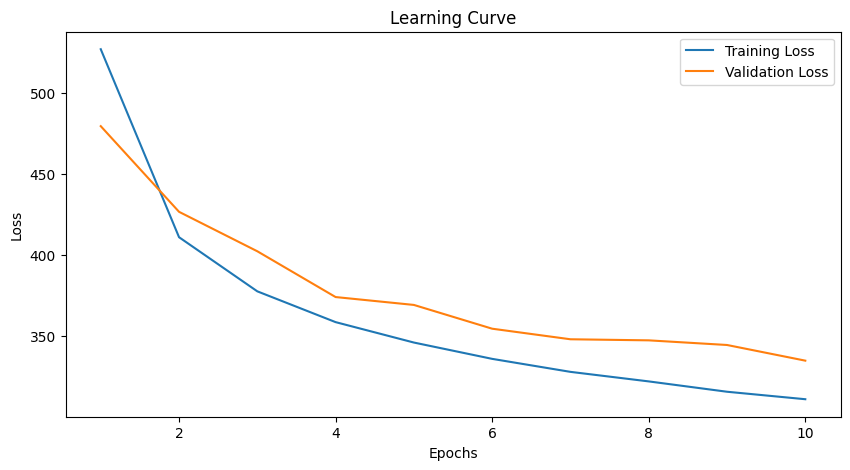

In [9]:
# Learning Curve 그리기
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_loss_mat, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses_mat, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Learning Curve')
plt.show()

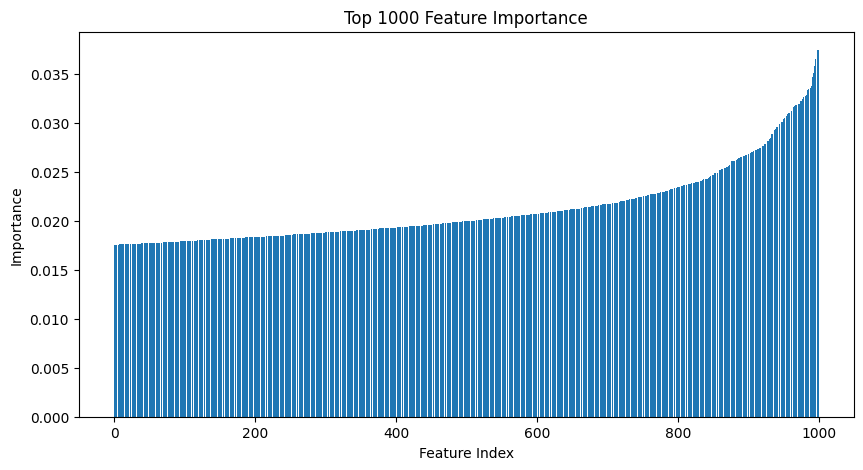

In [10]:
# 훈련 데이터셋에서 랜덤하게 이미지 선택
sample_image, _ = train_dataset[np.random.randint(len(train_dataset))]

# 모델의 forward pass 수행
model.eval()
with torch.no_grad():
    sample_image = sample_image.unsqueeze(0).to(device)
    outputs = model(sample_image)

# Feature Importance weight 적용하여 계산 및 CUDA 이동
ft_importance_map = torch.abs(model.fc.weight.squeeze(0)).detach().cpu().numpy()
ft_importance_map = torch.from_numpy(ft_importance_map).to(device)

# 상위 1000개 feature의 중요도 순으로 정렬
top_1000_features = np.argsort(ft_importance_map.cpu().numpy())[-1000:]

# 상위 1000개 feature 시각화
plt.figure(figsize=(10, 5))
plt.bar(range(len(top_1000_features)), ft_importance_map[top_1000_features].cpu())
plt.xlabel('Feature Index')
plt.ylabel('Importance')
plt.title('Top 1000 Feature Importance')
plt.show()


In [11]:
from torchsummary import summary
summary(model, input_size=(3,200,200), device='cuda')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                    [-1, 1]         120,001
Total params: 120,001
Trainable params: 120,001
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.46
Forward/backward pass size (MB): 0.00
Params size (MB): 0.46
Estimated Total Size (MB): 0.92
----------------------------------------------------------------
